In [ ]:
pip install pydub

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
from IPython.display import Audio
from scipy.io import wavfile
from scipy.fft import fft, ifft
from scipy.signal.windows import hamming, hann
from pydub import AudioSegment
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

Mounted at /content/drive


In [ ]:
filename = '/content/drive/MyDrive/piano_sample.mp3'
singlenote = '/content/drive/MyDrive/middlec.mp3'
ent = '/content/drive/MyDrive/audio.mp3'

input = singlenote

y, sr = librosa.load(input, sr=None)
harmonic, percussive = librosa.effects.hpss(y)

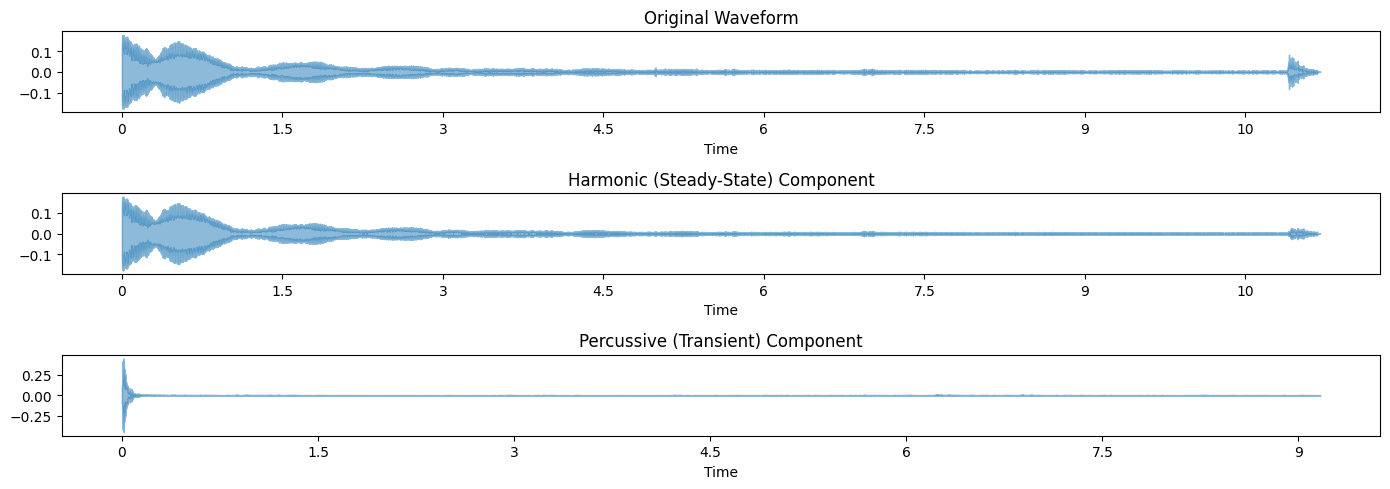

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(3, 1, 1)
librosa.display.waveshow(y[120000:1000000], sr=sr, alpha=0.5)
plt.title('Original Waveform')

plt.subplot(3, 1, 2)
librosa.display.waveshow(harmonic[120000:1000000], sr=sr, alpha=0.5)
plt.title('Harmonic (Steady-State) Component')

plt.subplot(3, 1, 3)
librosa.display.waveshow(percussive[60000:500000], sr=sr, alpha=0.5)
plt.title('Percussive (Transient) Component')

plt.tight_layout()
plt.show()

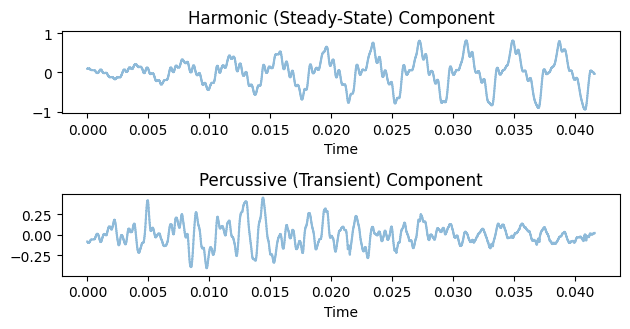

In [ ]:
plt.subplot(3, 1, 3)
librosa.display.waveshow(percussive[60000:62000], sr=sr, alpha=0.5)
plt.title('Percussive (Transient) Component')

plt.subplot(3, 1, 2)
librosa.display.waveshow(harmonic[60000:62000], sr=sr, alpha=0.5)
plt.title('Harmonic (Steady-State) Component')

plt.tight_layout()
plt.show()

In [ ]:
Audio(data=harmonic, rate=sr)

In [ ]:
Audio(data=percussive, rate=sr)

- Implement median filter to separate transient and ss
- Reading to understand the LMLs and GPs in general
- Spectrogram representation


**WEEK 2**

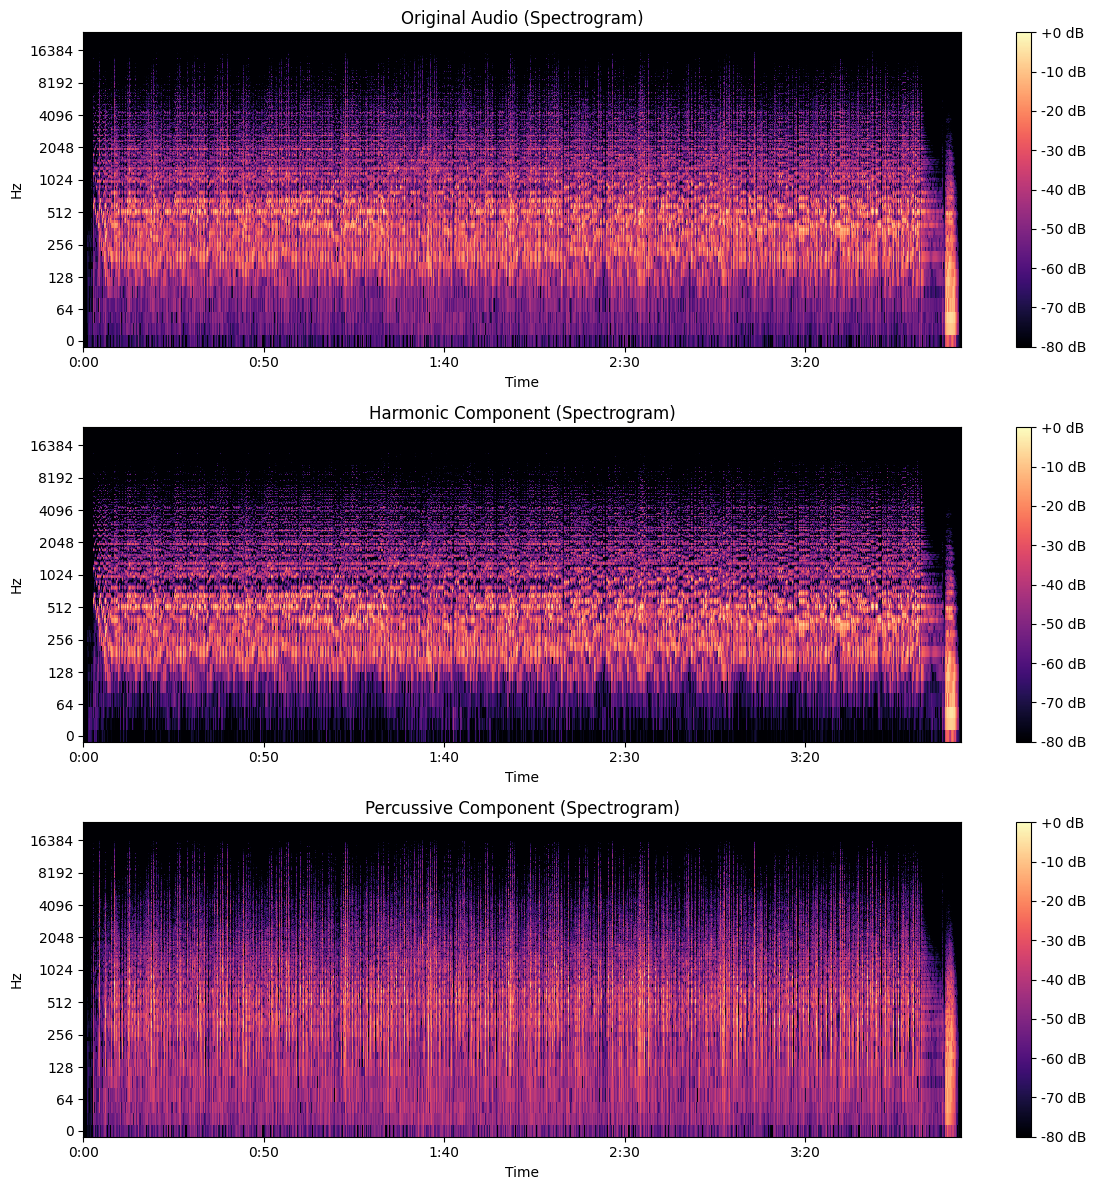

In [ ]:
D_original = librosa.stft(y)
D_harmonic = librosa.stft(harmonic)
D_percussive = librosa.stft(percussive)

D_original_db = librosa.amplitude_to_db(np.abs(D_original), ref=np.max)
D_harmonic_db = librosa.amplitude_to_db(np.abs(D_harmonic), ref=np.max)
D_percussive_db = librosa.amplitude_to_db(np.abs(D_percussive), ref=np.max)

plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
librosa.display.specshow(D_original_db, sr=sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Original Audio (Spectrogram)")

plt.subplot(3, 1, 2)
librosa.display.specshow(D_harmonic_db, sr=sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Harmonic Component (Spectrogram)")

plt.subplot(3, 1, 3)
librosa.display.specshow(D_percussive_db, sr=sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Percussive Component (Spectrogram)")

plt.tight_layout()
plt.show()

- Deriving the covariance for the tonal part
- Self constructing median filter/looking into tuning the median filtering
- Self constructed filter - running a window in frequency domain and compute the rolling median
- Likelihood functions for tonal and transient parts (basic white noise model for the transients)


**WEEK 4**

In [ ]:
pip install pydub

In [ ]:
from scipy.io import wavfile
from scipy.fft import fft, ifft
from scipy.signal.windows import hamming, hann
from pydub import AudioSegment

In [ ]:
audio = AudioSegment.from_file('/content/drive/MyDrive/middlec.mp3')
sample_rate = audio.frame_rate
audio_data = np.array(audio.get_array_of_samples())

window_size = 13
half_window = window_size // 2
time_window_size = 1024
hop_size = time_window_size // 2

processed_audio = np.zeros(len(audio_data))

time_hamming_window = hamming(time_window_size)
freq_hamming_window = hamming(window_size)

for start in range(0, len(audio_data) - time_window_size, hop_size):
    segment = audio_data[start:start + time_window_size].astype(np.float64)

    segment *= time_hamming_window

    segment_ft = fft(segment)

    filtered_segment_ft = np.copy(segment_ft)
    for i in range(half_window, len(segment_ft) - half_window):
        windowed_section = segment_ft[i - half_window:i + half_window + 1] * freq_hamming_window
        filtered_segment_ft[i] = np.median(np.abs(windowed_section)) # take care of taking median of complex numbers

    filtered_segment = ifft(filtered_segment_ft).real # reconstruct the original restoring the phase

    processed_audio[start:start + time_window_size] += filtered_segment * time_hamming_window

processed_audio = np.int16(processed_audio / np.max(np.abs(processed_audio)) * 32767)

#compare plots of filtered_segment and segment_ft
#use freq resolution to compute window size

In [ ]:
Audio(data=processed_audio, rate=sample_rate)

**DERIVATION OF COVARIANCE FUNCTION**

The power spectrum $ S(\omega) $ is modeled as a mixture of Gaussians:
$
S(\omega) = \sum_{q=1}^{Q} w_q \sum_{m=1}^{M} \frac{E_m}{2} \left[ \phi(\omega; m \omega_q, \sigma_f) + \phi(\omega; -m \omega_q, \sigma_f) \right]
$

where $ \phi(\omega; m \omega_q, \sigma_f) $ represents a Gaussian centered at $ m \omega_q $ with standard deviation $ \sigma_f $, and $ w_q $ and $ E_m $ are weights.


$
\phi(\omega; m \omega_q, \sigma_f) = \exp \left( -\frac{(\omega - m \omega_q)^2}{2 \sigma_f^2} \right)
$

$
\phi(\omega; -m \omega_q, \sigma_f) = \exp \left( -\frac{(\omega + m \omega_q)^2}{2 \sigma_f^2} \right)
$

To find the time-domain covariance function $ k(\tau) $, we take the IFT of $ S(\omega) $:
$
k(\tau) = \mathcal{F}^{-1} \left( S(\omega) \right)
$

Let's calculate the IFT of each Gaussian term individually.

IFT of $ \phi(\omega; m \omega_q, \sigma_f) $:
   The IFT of a Gaussian in the form $ \exp \left( -\frac{(\omega - m \omega_q)^2}{2 \sigma_f^2} \right) $ is another Gaussian in the time domain with an oscillatory component. Specifically:
   $
   \mathcal{F}^{-1} \left( \exp \left( -\frac{(\omega - m \omega_q)^2}{2 \sigma_f^2} \right) \right) = \exp \left( -2 \pi^2 \sigma_f^2 \tau^2 \right) \cos(2 \pi m f_q \tau)
   $
   where $ f_q = \frac{\omega_q}{2 \pi} $

Similarly:
   $
   \mathcal{F}^{-1} \left( \exp \left( -\frac{(\omega + m \omega_q)^2}{2 \sigma_f^2} \right) \right) = \exp \left( -2 \pi^2 \sigma_f^2 \tau^2 \right) \cos(2 \pi m f_q \tau)
   $

Combining Both Terms:
   $
   \mathcal{F}^{-1} \left( \frac{E_m}{2} \left[ \phi(\omega; m \omega_q, \sigma_f) + \phi(\omega; -m \omega_q, \sigma_f) \right] \right) = E_m \exp \left( -2 \pi^2 \sigma_f^2 \tau^2 \right) \cos(2 \pi m f_q \tau)
   $

Summing Over All Components
    $
    k(\tau) = \sum_{q=1}^{Q} w_q \sum_{m=1}^{M} E_m \exp \left( -2 \pi^2 \sigma_f^2 \tau^2 \right) \cos(2 \pi m f_q \tau)
    $

Factoring Out the Exponential Term
  Factor out the common term $ \exp \left( -2 \pi^2 \sigma_f^2 \tau^2 \right) $, giving the final result:
  $
  k(\tau) = \exp \left( -2 \pi^2 \sigma_f^2 \tau^2 \right) \sum_{q=1}^{Q} w_q \sum_{m=1}^{M} E_m \cos(2 \pi m f_q b_{m, f_q} \tau)
  $


**LOG-LIKELIHOOD FUNCTIONS**


$
\log p(\mathbf{y_{tonal}} | \mathbf{x}, \theta) = -\frac{1}{2} \mathbf{y}^T [K + \sigma_n^2 I]^{-1} \mathbf{y} - \frac{1}{2} \log |K + \sigma_n^2 I| - \frac{\ell}{2} \log(2\pi)
$

$
\log p(y_{percussive} | x, \theta) = -\frac{N}{2} \log (2 \pi \sigma^2_p) - \frac{1}{2 \sigma^2_p} \sum_{i=1}^N y_i^2
$

In [ ]:
import scipy.ndimage
import librosa.display

y, sr = librosa.load('/content/drive/MyDrive/middlec.mp3')

harmonic_window_length = 31
percussive_window_length = 31

window_type = "hamming"
overlap_ratio = 0.5
n_fft = 2048
hop_length = int(n_fft * (1 - overlap_ratio))
D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window_type)

S = np.abs(D)

harmonic_S = scipy.ndimage.median_filter(S, size=(1, harmonic_window_length))
percussive_S = scipy.ndimage.median_filter(S, size=(percussive_window_length, 1))

mask_harmonic = harmonic_S > percussive_S
mask_percussive = percussive_S >= harmonic_S

D_harmonic = D * mask_harmonic
D_percussive = D * mask_percussive

harmonic = librosa.istft(D_harmonic, hop_length=hop_length, window=window_type)
percussive = librosa.istft(D_percussive, hop_length=hop_length, window=window_type)

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title("Original Audio Waveform")

plt.subplot(3, 1, 2)
librosa.display.waveshow(harmonic, sr=sr)
plt.title("Harmonic Component")

plt.subplot(3, 1, 3)
librosa.display.waveshow(percussive, sr=sr)
plt.title("Percussive Component")

plt.tight_layout()
plt.show()

In [ ]:
Audio(data=harmonic, rate=sr)

In [ ]:
Audio(data=percussive, rate=sr)

**WEEK 5**

In [ ]:
audio = AudioSegment.from_file('/content/drive/MyDrive/middlec.mp3')
sample_rate = audio.frame_rate
audio_data = np.array(audio.get_array_of_samples())

window_size = 19
half_window = window_size // 2
time_window_size = 2048
hop_size = time_window_size // 2

processed_audio = np.zeros(len(audio_data))

time_hamming_window = hamming(time_window_size)
freq_hamming_window = hamming(window_size)

for start in range(0, len(audio_data) - time_window_size, hop_size):
    segment = audio_data[start:start + time_window_size].astype(np.float64)

    segment *= time_hamming_window

    segment_ft = fft(segment)

    filtered_segment_ft = np.copy(segment_ft)
    for i in range(half_window, (len(segment_ft)//2)):  # filter till halfway point and then mirror
        windowed_section = segment_ft[i - half_window:i + half_window + 1]

        median_magnitude = np.median(np.abs(windowed_section))
        filtered_segment_ft[i] = median_magnitude * np.exp(1j * np.angle(segment_ft[i]))

    filtered_segment = ifft(filtered_segment_ft).real

    processed_audio[start:start + time_window_size] += filtered_segment * time_hamming_window

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(np.abs(segment_ft))
    plt.title("Original Frequency Spectrum (Magnitude)")
    plt.xlabel("Frequency Bin")
    plt.ylabel("Magnitude")

    plt.subplot(1, 2, 2)
    plt.plot(np.abs(filtered_segment_ft))
    plt.title("Filtered Frequency Spectrum (Magnitude)")
    plt.xlabel("Frequency Bin")
    plt.ylabel("Magnitude")

    plt.tight_layout()
    plt.show()

processed_audio = np.int16(processed_audio / np.max(np.abs(processed_audio)) * 32767)

#frequency resolution to use the correct window size
#reconstruction of the time domain audio

In [ ]:
Audio(data=processed_audio, rate=sample_rate)

In [ ]:
processed_audio

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.waveshow(processed_audio[600000:700000].astype(np.float64), sr=sr)
plt.title("Transient Audio Waveform")

plt.tight_layout()
plt.show()

**WEEK 6**

In [ ]:
audio = AudioSegment.from_file('/content/drive/MyDrive/piano_sample.mp3')
sample_rate = audio.frame_rate
audio_data = np.array(audio.get_array_of_samples())
# audio_data = audio_data[0:1000000]

window_size = 19
half_window = window_size // 2
time_window_size = 2048
hop_size = time_window_size // 2

time_hamming_window = hamming(time_window_size)
freq_hamming_window = hamming(window_size)

processed_audio = np.zeros(len(audio_data))

for start in range(0, len(audio_data) - time_window_size, hop_size):
    segment = audio_data[start:start + time_window_size].astype(np.float64)
    segment *= time_hamming_window

    segment_ft = fft(segment)
    n = len(segment_ft)
    half_len = n // 2 + 1

    filtered_segment_ft = np.copy(segment_ft)

    for i in range(half_window, half_len):
        windowed_section = segment_ft[i - half_window:i + half_window + 1]
        median_magnitude = np.median(np.abs(windowed_section))
        filtered_segment_ft[i] = median_magnitude * np.exp(1j * np.angle(segment_ft[i]))

    if n % 2 == 0:  #even-length FFT
        filtered_segment_ft[half_len:] = np.conj(filtered_segment_ft[1:half_len - 1][::-1])
    else:  #odd-length FFT
        filtered_segment_ft[half_len:] = np.conj(filtered_segment_ft[1:half_len][::-1])

    filtered_segment = ifft(filtered_segment_ft).real

    processed_audio[start:start + time_window_size] += filtered_segment * time_hamming_window

processed_audio = np.int16(processed_audio / np.max(np.abs(processed_audio)) * 32767)

In [ ]:
Audio(data=processed_audio, rate=sample_rate*2)

In [ ]:
audio = AudioSegment.from_file('/content/drive/MyDrive/middlec.mp3')
sample_rate = audio.frame_rate
audio_data = np.array(audio.get_array_of_samples())
audio_data = audio_data[0:1000000]

window_size = 19
half_window = window_size // 2
time_window_size = 2048
hop_size = time_window_size // 2

time_hamming_window = hamming(time_window_size)

processed_audio = np.zeros(len(audio_data))

for start in range(0, len(audio_data) - time_window_size, hop_size):
    segment = audio_data[start:start + time_window_size].astype(np.float64)
    segment *= time_hamming_window

    segment_ft = fft(segment)
    n = len(segment_ft)
    half_len = n // 2 + 1

    filtered_segment_ft = np.copy(segment_ft)

    for i in range(half_window, half_len):
        windowed_section = segment_ft[i - half_window:i + half_window + 1]
        median_magnitude = np.median(np.abs(windowed_section))
        filtered_segment_ft[i] = min(median_magnitude, np.abs(segment_ft[i])) * np.exp(1j * np.angle(segment_ft[i]))

    if n % 2 == 0:  #even-length FFT
        filtered_segment_ft[half_len:] = np.conj(filtered_segment_ft[1:half_len - 1][::-1])
    else:  #odd-length FFT
        filtered_segment_ft[half_len:] = np.conj(filtered_segment_ft[1:half_len][::-1])

    filtered_segment = ifft(filtered_segment_ft).real

    processed_audio[start:start + time_window_size] += filtered_segment * time_hamming_window

processed_audio = np.int16(processed_audio / np.max(np.abs(processed_audio)) * 32767)

In [ ]:
Audio(data=processed_audio, rate=sample_rate*2)

Output hidden; open in https://colab.research.google.com to view.

- Progress report
- Runtime fixes
- Presentation slides

- Tuning the separator
- Gaussian process model using the derived likelihood functions
- Making a start on the presentation
- Transient method separation techniques

**WEEK 7**

In [ ]:
audio = AudioSegment.from_file('/content/drive/MyDrive/audio.mp3')
sample_rate = audio.frame_rate
audio_data = np.array(audio.get_array_of_samples())
audio_data = audio_data

window_size = 19
half_window = window_size // 2
time_window_size = 2048
hop_size = time_window_size // 2

alpha = 0.4

time_hamming_window = hann(time_window_size)

processed_audio = np.zeros(len(audio_data))

for start in range(0, len(audio_data) - time_window_size, hop_size):
    segment = audio_data[start:start + time_window_size].astype(np.float64)
    segment *= time_hamming_window

    segment_ft = fft(segment)
    n = len(segment_ft)
    half_len = n // 2 + 1

    filtered_segment_ft = np.copy(segment_ft)

    for i in range(0, half_len):  # median filtering from the very first element of the FT!
        start_idx = max(0, i - half_window)
        end_idx = i + half_window

        windowed_section = segment_ft[start_idx:end_idx + 1]
        median_magnitude = np.median(np.abs(windowed_section)) * alpha

        filtered_segment_ft[i] = min(median_magnitude, np.abs(segment_ft[i])) * np.exp(1j * np.angle(segment_ft[i]))

        phase = np.angle(filtered_segment_ft)
        randomized_phase = np.random.uniform(-np.pi, np.pi, len(phase))
        filtered_segment_ft = np.abs(filtered_segment_ft) * np.exp(1j * randomized_phase)

    if n % 2 == 0:  #even-length FFT
        filtered_segment_ft[half_len:] = np.conj(filtered_segment_ft[1:half_len - 1][::-1])
    else:  #odd-length FFT
        filtered_segment_ft[half_len:] = np.conj(filtered_segment_ft[1:half_len][::-1])

    filtered_segment = ifft(filtered_segment_ft).real

    processed_audio[start:start + time_window_size] += filtered_segment * time_hamming_window

    frequencies = np.fft.rfftfreq(len(segment_ft), d=1/(sample_rate*2))

    # plt.figure(figsize=(14, 6))

    # # Assuming frequencies, segment_ft, and filtered_segment_ft are already defined
    # # (limiting the display to frequencies below 6000Hz)
    # freq_limit = 6000
    # indices_below_limit = frequencies <= freq_limit

    # # Plot only the relevant portion
    # plt.plot(frequencies[indices_below_limit], np.abs(segment_ft[:len(frequencies)][indices_below_limit]), label="Original Spectrum")
    # plt.plot(frequencies[indices_below_limit], np.abs(filtered_segment_ft[:len(frequencies)][indices_below_limit]), color='r', label="Filtered Spectrum")

    # plt.title("Frequency Spectrum (Magnitude)")
    # plt.xlabel("Frequency (Hz)")
    # plt.ylabel("Magnitude")
    # plt.grid(True, which="both", linestyle='--')
    # plt.xlim(0, freq_limit)  # Limit x-axis to 6000Hz
    # plt.xticks(range(0, freq_limit + 1000, 1000), [f"{x} Hz" for x in range(0, freq_limit + 1000, 1000)])

    # plt.tight_layout()
    # plt.legend()
    # plt.show()

processed_audio = np.int16(processed_audio / np.max(np.abs(processed_audio)) * 32767)

In [ ]:
Audio(data=audio_data, rate=sample_rate*2)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
Audio(data=processed_audio, rate=sample_rate*2)


Output hidden; open in https://colab.research.google.com to view.

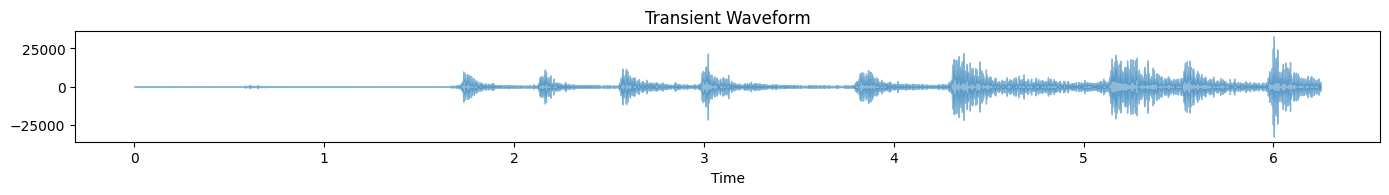

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(3, 1, 1)
librosa.display.waveshow(processed_audio[60000:360000].astype(np.float64), sr=sample_rate, alpha=0.5)
plt.title('Transient Waveform')

plt.tight_layout()
plt.show()

In [ ]:
np.savetxt('transientsample.txt', processed_audio)

In [ ]:
from scipy.io.wavfile import write

wav_path = '/content/drive/MyDrive/transient_response.wav'
write(wav_path, sample_rate, (y[:len(processed_audio)]))  # Scale to 16-bit

# Step 2: Convert the WAV file to MP3 using pydub
mp3_path = '/content/drive/MyDrive/transient_response.mp3'
audio = AudioSegment.from_wav(wav_path)
audio.export(mp3_path, format="mp3")


print(f"Audio saved as MP3: {mp3_path}")

Audio saved as MP3: /content/drive/MyDrive/transient_response.mp3


In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, RationalQuadratic

# Assume processed_audio is the audio signal (numpy array) with sample_rate as the sample rate
sample_rate = 44100  # Adjust this if different
onset_frames = librosa.onset.onset_detect(y=processed_audio.astype(np.float64), sr=sample_rate)
onset_times = librosa.frames_to_time(onset_frames, sr=sample_rate)

# Select the first five onsets
first_five_onsets = onset_frames[:5]

# Extract segments around the first five onsets
window_size = 700  # 0.1-second window around each onset
onset_segments = []

for onset in first_five_onsets:
    start = max(0, onset * 512 - window_size // 2)
    end = min(len(processed_audio), onset * 512 + window_size // 2)
    onset_segments.append(processed_audio[start:end])

# Fit a GP model to each onset segment
kernel = WhiteKernel(noise_level=100) + RationalQuadratic(length_scale=1, alpha=0.5)

for i, segment in enumerate(onset_segments):
    # Generate time points for the segment
    duration = len(segment) / sample_rate
    time_points = np.linspace(0, duration, len(segment)).reshape(-1, 1)

    # Fit Gaussian Process
    gp = GaussianProcessRegressor(kernel=kernel, random_state=0)
    gp.fit(time_points, segment)

    # Predict using GP
    time_points_pred = np.linspace(0, duration, len(segment)).reshape(-1, 1)
    waveform_pred, std_pred = gp.predict(time_points_pred, return_std=True)

    # Plot the results
    plt.figure(figsize=(12, 6))  # Create a new figure for each onset
    plt.plot(time_points, segment, 'r.', markersize=2, label="Original Segment")
    plt.plot(time_points_pred, waveform_pred, 'b-', label="GP Prediction")
    plt.fill_between(
        time_points_pred.flatten(),
        waveform_pred - 1.96 * std_pred,
        waveform_pred + 1.96 * std_pred,
        alpha=0.2,
        color="blue",
        label="95% Confidence Interval"
    )
    plt.title(f"Onset {i + 1}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()


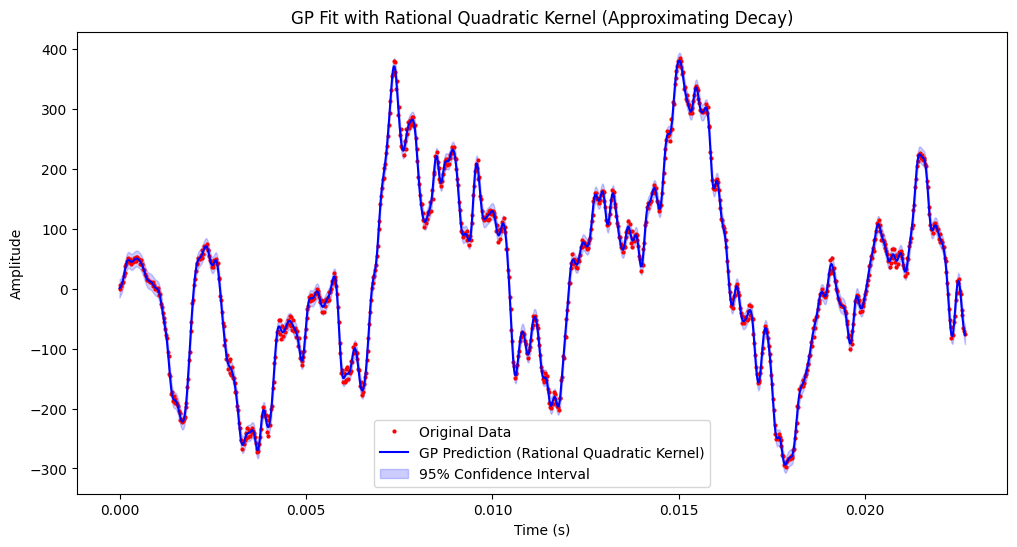

WhiteKernel(noise_level=0.00165) + RationalQuadratic(alpha=0.249, length_scale=0.0462)


In [ ]:
# Re-import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, WhiteKernel




import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, RationalQuadratic

# Assume processed_audio is the audio signal (numpy array) with sample_rate as the sample rate
sample_rate = 44100  # Adjust this if different
onset_frames = librosa.onset.onset_detect(y=processed_audio.astype(np.float64), sr=sample_rate)
onset_times = librosa.frames_to_time(onset_frames, sr=sample_rate)

# Select the first five onsets
first_five_onsets = onset_frames[:5]

# Extract segments around the first five onsets
window_size = 1000  # 0.1-second window around each onset
onset_segments = []

for onset in first_five_onsets:
    start = max(0, onset * 512 - window_size // 2)
    end = min(len(processed_audio), onset * 512 + window_size // 2)
    onset_segments.append(processed_audio[start:end])

y_data = onset_segments[1]
# Correct the variable name
duration = len(y_data) / sample_rate
x_data = np.linspace(0, duration, len(y_data)).reshape(-1, 1)

# Normalize x_data and y_data
from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_data_scaled = x_scaler.fit_transform(x_data)
y_data_scaled = y_scaler.fit_transform(y_data.reshape(-1, 1)).flatten()

# Use default kernel hyperparameters
kernel = WhiteKernel() + RationalQuadratic()

# Initialize GP with hyperparameter optimization allowed
gp = GaussianProcessRegressor(kernel=kernel, random_state=0)

# Fit the GP model
gp.fit(x_data_scaled, y_data_scaled)

# Make predictions
x_pred_scaled = x_scaler.transform(x_data)
y_pred_scaled, y_std_scaled = gp.predict(x_pred_scaled, return_std=True)

# Inverse transform the predictions to the original scale
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_std = y_std_scaled * y_scaler.scale_[0]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(x_data, y_data, 'r.', markersize=4, label="Original Data")
plt.plot(x_data, y_pred, 'b-', label="GP Prediction (Rational Quadratic Kernel)")
plt.fill_between(
    x_data.flatten(),
    y_pred - 1.96 * y_std,
    y_pred + 1.96 * y_std,
    alpha=0.2,
    color="blue",
    label="95% Confidence Interval"
)
plt.title("GP Fit with Rational Quadratic Kernel (Approximating Decay)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

# Display the fitted kernel and its parameters
print(gp.kernel_)


**WEEK 8**

In [ ]:
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

class NoteOnsetDetector:
    def __init__(self):
        self.model = LogisticRegression()  # Initialize logistic regression model

    def preprocess_audio(self, audio):
        """
        Load and preprocess the audio file.
        """
        onset_env = librosa.onset.onset_strength(y=audio, sr=sr)
        onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr)
        return onset_frames, onset_env

    def extract_transient_features(self, y, sr, onset_frames):
        """
        Extract features from detected transients.
        """
        features = []
        for onset in onset_frames:
            start = max(0, onset - int(sr * 0.05))  # 50 ms before onset
            end = min(len(y), onset + int(sr * 0.2))  # 200 ms after onset
            segment = y[start:end]

            # Fit exponential decay
            t = np.linspace(0, len(segment) / sr, len(segment))
            envelope = np.abs(segment)
            decay_rate = np.polyfit(t, np.log(envelope + 1e-10), 1)[0]  # Log-linear fit

            # Frequency content (spectral centroid)
            freq = librosa.feature.spectral_centroid(y=segment, sr=sr).mean()

            # Amplitude and energy
            amplitude = np.max(np.abs(segment))
            energy = np.sum(segment ** 2)

            # Collect features
            features.append([decay_rate, freq, amplitude, energy])

        return np.array(features)

    def train_model(self, features, labels):
        """
        Train the logistic regression model using features and labels.
        """
        X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
        self.model.fit(X_train, y_train)
        accuracy = self.model.score(X_test, y_test)
        print(f"Model accuracy: {accuracy:.2f}")

    def predict_onsets(self, features):
        """
        Predict onset probabilities for extracted features.
        """
        probabilities = self.model.predict_proba(features)[:, 1]
        return probabilities

    def process_audio_file(self, audio, labels=None):
        """
        Full pipeline to preprocess, extract features, train model (if labels provided),
        and predict onset probabilities.
        """
        print("Preprocessing audio...")
        onset_frames, onset_env = self.preprocess_audio(audio)

        print("Extracting features...")
        features = self.extract_transient_features(audio, sr, onset_frames)

        if labels is not None:
            # Check and adjust the number of labels
            if len(labels) != len(features):
                print(f"Adjusting labels to match the number of features: {len(features)}")
                labels = np.ones(len(features))

            print("Training model...")
            self.train_model(features, labels)

        print("Predicting probabilities...")
        probabilities = self.predict_onsets(features)

        return probabilities


# if __name__ == "__main__":

#     detector = NoteOnsetDetector()

#     sr=44100

#     probabilities = detector.process_audio_file(processed_audio.astype(np.float64), labels=labels)

#     print("Onset Probabilities:", probabilities)
